In [125]:
import pandas as pd
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.base import TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from matplotlib import pyplot as plt
%matplotlib inline

In [126]:
df_data = pd.read_csv('data/train.csv')
df_data.shape

(1460, 81)

In [127]:
print(df_data.columns)
print(df_data.columns.size)
print(df_data.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [128]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 1. Предобработка

### 1.1 Missing Data

In [129]:
# missing data
total = df_data.isnull().sum().sort_values(ascending=False)
percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [189]:
#columns_with_too_much_missing_data = percent[percent > 0.8].index.values
columns_with_too_much_missing_data = percent[percent > 0.9].index.values
print('Columns with too much missing data:')
print(columns_with_too_much_missing_data)

# remove the 'Id' column
columns_to_remove = np.append(columns_with_too_much_missing_data, ['Id'])
print('Columns to remove:')
print(columns_to_remove)

Columns with too much missing data:
['PoolQC' 'MiscFeature' 'Alley']
Columns to remove:
['PoolQC' 'MiscFeature' 'Alley' 'Id']


Анализировал пропущенные значения. Пока думаю так:

* удалить колонки с > 90% пропущенных значений. Это PoolQC, MiscFeature, Alley.
* для категориальных признаков: пропущенное значение выделить в отдельную категорию. Назвать ее как-то. Эти пропущенные значения имеют осмысленный характер, так как, судя по данным, обусловлены отсуствием той или иной характеристики у объекта наблюдения.
* для числовых признаков: Применить Imputer, strategy=mean

Остается вопрос с колонкой Id.

In [169]:
class DataFrameColumnsRemove(TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self._feature_names, axis='columns')

### 1.2 Outliers

Поискать выбросы по разным признакам в рамках анализа данных в предыдущем ноутбуке. Удалить, что найдется.

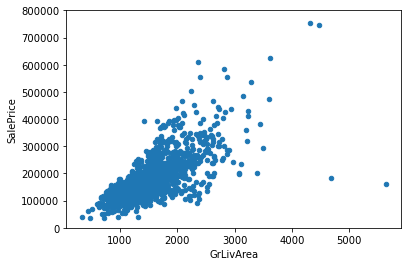

In [132]:
var = 'GrLivArea'
data = pd.concat([df_data['SalePrice'], df_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [133]:
df_data[df_data['GrLivArea'] > 4000][['Id','GrLivArea']]

,Id,GrLivArea
523,524,4676
691,692,4316
1182,1183,4476
1298,1299,5642


In [134]:
#deleting points
df_data.sort_values(by='GrLivArea', ascending=False)[:2]
df_data = df_data.drop(df_data[df_data['Id'] == 1299].index)
df_data = df_data.drop(df_data[df_data['Id'] == 524].index)

In [135]:
df_data.shape

(1458, 81)

Удалили пока только выбросы по признаку 'GrLivArea'

### 1.3 Preprocessing pipeline 

In [170]:
columns_to_remove

array(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], dtype=object)

### 1.3.2 Ordinal encoded features

С признаком "BldgType" есть несоответствия между data_description и реальными значениями. Чтобы не допустить тут ошибки в определении порядка значений, думаю, лучше его не добавлять в этот процесс.

In [195]:
#'MSZoning': ['A', 'I', 'C (all)', 'FV', 'RH', 'RM', 'RL', 'RP']

ordered_cat_feature_values_dict = {
    'Street': ['Grvl', 'Pave'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandContour': ['Low', 'Bnk', 'HLS', 'Lvl'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'HouseStyle': ['1Story', 'SFoyer', 'SLvl', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': [np.nan, 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': [np.nan, 'Unf', 'LwQ', 'BLQ', 'Rec', 'ALQ', 'GLQ'],
    'BsmtFinType2': [np.nan, 'Unf', 'LwQ', 'BLQ', 'Rec', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'CentralAir': ['N', 'Y'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': [np.nan, 'Unf', 'RFn', 'Fin'],
    'GarageQual': [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y']
}

cat_feature_num_values_dict = \
    {feature: dict(zip(ordered_values, list(range(1, len(ordered_values) + 1)))) \
    for feature, ordered_values in ordered_cat_feature_values_dict.items()}

In [196]:
cat_feature_num_values_dict

{'Street': {'Grvl': 1, 'Pave': 2},
 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
 'LandContour': {'Low': 1, 'Bnk': 2, 'HLS': 3, 'Lvl': 4},
 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4},
 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3},
 'HouseStyle': {'1Story': 1,
  'SFoyer': 2,
  'SLvl': 3,
  '1.5Unf': 4,
  '1.5Fin': 5,
  '2Story': 6,
  '2.5Unf': 7,
  '2.5Fin': 8},
 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
 'BsmtQual': {nan: 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
 'BsmtCond': {nan: 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
 'BsmtExposure': {nan: 1, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5},
 'BsmtFinType1': {nan: 1,
  'Unf': 2,
  'LwQ': 3,
  'BLQ': 4,
  'Rec': 5,
  'ALQ': 6,
  'GLQ': 7},
 'BsmtFinType2': {nan: 1,
  'Unf': 2,
  'LwQ': 3,
  'BLQ': 4,
  'Rec': 5,
  'ALQ': 6,
  'GLQ': 7},
 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
 'CentralAir': {'N': 1, 'Y':

In [139]:
class CustomOrdinalEncoder(TransformerMixin):
    def __init__(self, cat_feature_num_values_dict):
        self._cat_feature_num_values_dict = cat_feature_num_values_dict
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result_df = X.copy()
        for feature in self._cat_feature_num_values_dict.keys():
            result_df[feature] = X[feature].map(self._cat_feature_num_values_dict[feature])
        return result_df

In [140]:
#df_data[df_data['BsmtFinType2'].isnull() == True]['BsmtFinType2']
#test_series = df_data['BsmtFinType2'].map(ordered_feature_num_values_dict['BsmtFinType2'])
#test_series[test_series.isnull() == True]

#df_data[ordered_feature_num_values_dict.keys()]
#df_data[df_data['BldgType'].isnull() == True]['BldgType']
#df_data[ordered_feature_num_values_dict.keys()].isnull().sum()

In [141]:
#def test_transform_ordered_cat_to_num(df_data):
#for dict_key in ordered_feature_num_values_dict.keys():
#    df_data[dict_key] = df_data[dict_key].map(ordered_feature_num_values_dict[dict_key])

#### Preprocessing Pipelines

##### StandardScaler

If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [142]:
remove_columns_transformer = DataFrameColumnsRemove(columns_to_remove)

#num_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

#cat_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='<missing>'))])

num_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                                   ('scaler', StandardScaler())])


cat_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='<missing>')),
                                   ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])


column_type_based_preprocess_transformer = ColumnTransformer([
    ('numerical', num_preprocess_pipeline, make_column_selector(dtype_include='number')),
    ('categorical', cat_preprocess_pipeline, make_column_selector(dtype_include='object'))
])

preprocessing_pipeline = Pipeline([('remove_columns', remove_columns_transformer),
                                  ('column_based_preprocess_pipeline', column_type_based_preprocess_transformer)])

In [197]:
remove_columns_transformer = DataFrameColumnsRemove(columns_to_remove)
custom_ordinal_encoder = CustomOrdinalEncoder(cat_feature_num_values_dict)

#num_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

#cat_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='<missing>'))])

num_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                                   ('scaler', StandardScaler())])


cat_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='<missing>')),
                                   ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])


column_type_based_preprocess_transformer = ColumnTransformer([
    ('numerical', num_preprocess_pipeline, make_column_selector(dtype_include='number')),
    ('categorical', cat_preprocess_pipeline, make_column_selector(dtype_include='object'))
])

#preprocessing_pipeline = Pipeline([('remove_columns', remove_columns_transformer),
#                                  ('column_based_preprocess_pipeline', column_type_based_preprocess_transformer)])


preprocessing_pipeline_cat_ordinal = Pipeline([('remove_columns', remove_columns_transformer),
                                    ('custom_ordinal_encoder', custom_ordinal_encoder),
                                    ('column_based_preprocess_pipeline', column_type_based_preprocess_transformer)])

In [14]:
#test
preprocessed_data_test = preprocessing_pipeline.fit_transform(df_data)
preprocessed_data_test

<1458x292 sparse matrix of type '<class 'numpy.float64'>'
	with 112007 stored elements in Compressed Sparse Row format>

In [15]:
#test
print(preprocessed_data_test.toarray()[0].size)
preprocessed_data_test.toarray()[0]

292


array([ 0.07342554, -0.22808532, -0.20341024,  0.65850569, -0.5176494 ,
        1.05295943,  0.88036165,  0.52125624,  0.61728311, -0.28886725,
       -0.94379532, -0.4737659 , -0.81430891,  1.1676262 , -0.12032536,
        0.3930128 ,  1.11388595, -0.24123593,  0.79354567,  1.22969871,
        0.16389443, -0.21160505,  0.92181186, -0.95223126,  1.02323777,
        0.31315878,  0.35797333, -0.7508307 ,  0.2259816 , -0.35960311,
       -0.11642013, -0.27040716, -0.06370868, -0.0877484 , -1.60157805,
        0.1383752 ,  0.34689629,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.  

In [16]:
#test
num_vars = df_data.select_dtypes(include='number').columns
cat_vars = df_data.select_dtypes(include='object').columns
print(num_vars.size)
print(cat_vars.size)

38
43


In [184]:
preprocessed_data_test_ordinal = custom_ordinal_encoder.fit_transform(df_data)
preprocessed_data_test_ordinal['MSZoning'].isnull().sum()
#preprocessed_data_test_ordinal['MSZoning'][5:10]

10

In [181]:
#test 2
preprocessed_data_test_ordinal = test_preprocess_pipeline.fit_transform(df_data)
print(preprocessed_data_test_ordinal[0].size)
preprocessed_data_test_ordinal[0]

210


array([ 0.07342554, -0.22808532, -0.20341024,  0.06428243,  0.70210024,
        0.30871097,  0.02619813,  0.22587878,  1.21689695,  0.65850569,
       -0.5176494 ,  1.05295943,  0.88036165,  0.52125624,  1.06110904,
       -0.23828489,  0.58632935,  0.11796619, -0.58910196,  1.17137838,
        0.61728311, -0.28229584, -0.28886725, -0.94379532, -0.4737659 ,
        0.89227664,  0.26400605, -0.81430891,  1.1676262 , -0.12032536,
        0.3930128 ,  1.11388595, -0.24123593,  0.79354567,  1.22969871,
        0.16389443, -0.21160505,  0.74112686,  0.92181186,  0.23721521,
       -0.95223126, -1.00699314,  1.02323777,  0.32068452,  0.31315878,
        0.35797333,  0.26273445,  0.26581303,  0.28996012, -0.7508307 ,
        0.2259816 , -0.35960311, -0.11642013, -0.27040716, -0.06370868,
       -0.0877484 , -1.60157805,  0.1383752 ,  0.34689629,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.  

### [Эксперименты] 1.4 OneHotEncoder, анализ собственных значений

use function DataFrame.dtypes

In [17]:
df_data.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [18]:
# test transform of single categorical feature
encoder = OneHotEncoder()
street_feature_as_array = df_data['Street'].to_numpy().reshape(-1, 1)
transformed_array_sparse_mtx = encoder.fit_transform(street_feature_as_array)
print(type(transformed_array_sparse_mtx))
print(encoder.categories_)
transformed_array = transformed_array_sparse_mtx.toarray()
print(transformed_array)
print('Grvl element: ' + str(transformed_array[52]))

<class 'scipy.sparse.csr.csr_matrix'>
[array(['Grvl', 'Pave'], dtype=object)]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Grvl element: [1. 0.]


Пишут, что гораздо чаще используется кросс-валидация, чем hold-out (отложенная выборка). См. закладки

### Анализ собственный значений 

In [19]:
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import inv

In [20]:
XtX = np.dot(np.transpose(preprocessed_data_test), preprocessed_data_test)
print(XtX.shape)

(292, 292)


In [21]:
e_vals, e_vectors = eigs(XtX, 290)
e_vals

array([ 3.67643779e+04+0.00000000e+00j,  1.35148288e+04+0.00000000e+00j,
        5.39170859e+03+0.00000000e+00j,  4.60186551e+03+0.00000000e+00j,
        3.37076469e+03+0.00000000e+00j,  2.41934772e+03+0.00000000e+00j,
        1.98167976e+03+0.00000000e+00j,  1.95128111e+03+0.00000000e+00j,
        1.78466459e+03+0.00000000e+00j,  1.70273465e+03+0.00000000e+00j,
        1.73273841e+03+0.00000000e+00j,  1.61185520e+03+0.00000000e+00j,
        1.57314917e+03+0.00000000e+00j,  1.54316255e+03+0.00000000e+00j,
        1.50829134e+03+0.00000000e+00j,  1.45422140e+03+0.00000000e+00j,
        1.36033398e+03+0.00000000e+00j,  1.33238175e+03+0.00000000e+00j,
        1.30841583e+03+0.00000000e+00j,  1.23301097e+03+0.00000000e+00j,
        1.16688554e+03+0.00000000e+00j,  1.09967139e+03+0.00000000e+00j,
        1.03219809e+03+0.00000000e+00j,  9.39252062e+02+0.00000000e+00j,
        9.25405968e+02+0.00000000e+00j,  8.86146692e+02+0.00000000e+00j,
        7.33921480e+02+0.00000000e+00j,  6.77194817

In [22]:
# this command sometimes throws "Factor is exactly singular", so we comment it out.
#eigs(inv(XtX), 100);

min eigenvalues:       
       
       -1.46936091e-13-3.36501025e-13j,  4.00680184e-14+3.36715826e-13j,
        4.00680184e-14-3.36715826e-13j,  3.27847335e-13+4.83837074e-14j,
        3.27847335e-13-4.83837074e-14j,  3.06952410e-13+0.00000000e+00j,
        2.39065398e-13+1.67944371e-13j,  2.39065398e-13-1.67944371e-13j,
       -2.58602867e-13+1.06867170e-13j, -2.58602867e-13-1.06867170e-13j,
       -2.85274987e-13+0.00000000e+00j, -1.07135117e-13+2.36030486e-13j,
       -1.07135117e-13-2.36030486e-13j,  3.35811568e-14+2.24558764e-13j,
        3.35811568e-14-2.24558764e-13j,  1.41673084e-13+1.39878617e-13j,
        1.41673084e-13-1.39878617e-13j, -1.51199098e-13+1.18577370e-13j,
       -1.51199098e-13-1.18577370e-13j,  5.29510951e-14+1.52263207e-13j,
        5.29510951e-14-1.52263207e-13j, -1.22751738e-13+4.93295961e-14j,
       -1.22751738e-13-4.93295961e-14j, -1.24677735e-13+0.00000000e+00j,
        1.09252641e-13+0.00000000e+00j,  3.00100431e-14+9.49647064e-14j,
        3.00100431e-14-9.49647064e-14j, -3.10036527e-15+5.30780476e-14j,
       -3.10036527e-15-5.30780476e-14j,  3.44370538e-14+0.00000000e+00j,
       -2.31522579e-14+0.00000000e+00j,  8.12223381e-15+5.72864175e-15j,
        8.12223381e-15-5.72864175e-15j, -1.84537544e-20+0.00000000e+00j,
        4.71461149e-18+0.00000000e+00j,  3.24852434e-28+0.00000000e+00j

In [23]:
condition_num = abs(e_vals.max())/abs(e_vals.min())
print('Число обусловленности матрицы: ' + str(condition_num))

Число обусловленности матрицы: 3836436914511114.0


Число обусловленности матрицы очень велико, то есть задача плохо обусловлена. Признак мультиколлинеарности.
Можно попробовать решить проблему с помощью регуляризации.
Дописать про последствия мультиколлинеарности завтра... 

См. пример в конспекте (неделя 2, пункт 1), а также в лекция Воронцова. Очень много близких к оптимальному алгоритмов (наборов весов), оптимальных наборов весов. Веса получаются ненадежные, не устойчивые к изменениям в данных.

При некоторых входных данных возникает даже такая ошибка:
RuntimeError: Factor is exactly singular
при вызове eigs()

То есть матрица вырожденная.

### 2. Train-test split (hold-out). Estimator 

In [158]:
from sklearn.model_selection import train_test_split

df_data_X = df_data.iloc[:,:-1]
df_data_y = df_data.iloc[:,-1]

train_X, test_X, train_y, test_y = train_test_split(df_data_X, df_data_y, test_size=0.3, random_state=19)

### Метрика 

In [159]:
log_rmse_metric = make_scorer(lambda y_true, y_pred: \
                            mean_squared_error(np.log(y_true), np.log(y_pred), squared=False), greater_is_better=False)

#В режиме leave-one-out np.log не работает..

#### ColumnTransformer (StandardScaler + OneHotEncoder)

###### StandardScaler info
If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [37]:
#log_rmse_metric = make_scorer(\
#    lambda y_true, y_pred: mean_squared_error(np.log(y_true), np.log(y_pred), squared=False), greater_is_better=False)

## Linear models 

Info:
https://scikit-learn.org/stable/modules/linear_model.html

### Model 1. Standard Linear Regression, without regularization

The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix  have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

In [38]:
model = LinearRegression()
pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', model)])
pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x000002BB81A93EB0>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002BB81AA8190>),
                                                                  ('categorical',
                              

In [39]:
cat_feature_names = preprocessing_pipeline.named_steps['column_based_preprocess_pipeline'].transformers_[1][1].\
named_steps['one_hot_encoder'].get_feature_names()
cat_feature_names

array(['x0_C (all)', 'x0_FV', 'x0_RH', 'x0_RL', 'x0_RM', 'x1_Grvl',
       'x1_Pave', 'x2_IR1', 'x2_IR2', 'x2_IR3', 'x2_Reg', 'x3_Bnk',
       'x3_HLS', 'x3_Low', 'x3_Lvl', 'x4_AllPub', 'x4_NoSeWa',
       'x5_Corner', 'x5_CulDSac', 'x5_FR2', 'x5_FR3', 'x5_Inside',
       'x6_Gtl', 'x6_Mod', 'x6_Sev', 'x7_Blmngtn', 'x7_Blueste',
       'x7_BrDale', 'x7_BrkSide', 'x7_ClearCr', 'x7_CollgCr',
       'x7_Crawfor', 'x7_Edwards', 'x7_Gilbert', 'x7_IDOTRR',
       'x7_MeadowV', 'x7_Mitchel', 'x7_NAmes', 'x7_NPkVill', 'x7_NWAmes',
       'x7_NoRidge', 'x7_NridgHt', 'x7_OldTown', 'x7_SWISU', 'x7_Sawyer',
       'x7_SawyerW', 'x7_Somerst', 'x7_StoneBr', 'x7_Timber',
       'x7_Veenker', 'x8_Artery', 'x8_Feedr', 'x8_Norm', 'x8_PosA',
       'x8_PosN', 'x8_RRAe', 'x8_RRAn', 'x8_RRNe', 'x8_RRNn', 'x9_Artery',
       'x9_Feedr', 'x9_Norm', 'x9_PosA', 'x9_PosN', 'x9_RRAe', 'x9_RRAn',
       'x9_RRNn', 'x10_1Fam', 'x10_2fmCon', 'x10_Duplex', 'x10_Twnhs',
       'x10_TwnhsE', 'x11_1.5Fin', 'x11_1.5Unf'

In [40]:
print(model.coef_[:50])
print(model.coef_[-50:])
print(model.coef_.size)

[  2436.42911814   1132.38094945   6854.7772293    8827.7484443
   8059.75081552  11127.07450668   2121.00624818   3727.14703915
  11275.42644737   1223.70536311    538.26158107  12520.27456082
   6012.33852933  17276.27996299  -2074.53902255  18764.586385
   -541.3636808      97.84744941   2327.37870374   -544.60566601
  -5378.75620466  -1537.69068151   2953.44968399   3981.2100373
   -370.31976991   4907.93030804    598.01050394    937.71437506
    345.05123394    886.09077471   1129.30574237    713.03454706
   2515.37604035   -207.7568739   -1032.65278768  -1139.70889114
  -2966.49292932   2346.5522918   -2916.06110649   2686.22634143
    849.77540251 -31440.98437252  31440.98437254   2286.89484854
    -83.50088719  -4030.72187915   1827.32791774   3328.02769845
   2564.97449384  -6670.39167159]
[ -8446.7698067   -1026.4375549    8240.90820711  -1010.85767631
  -6553.4777464    2640.30722085   -150.98757551  -2986.13768328
   5318.57756007  -2700.08418312   4431.80240735   2640.3072

In [41]:
predicted_y = pipeline.predict(test_X)
print(predicted_y[:5])
print(predicted_y[-5:])

[106875.68937917 354809.17633693  98911.9082323  159041.46518521
 211265.8984094 ]
[224342.34673543 358436.30409429 179570.73619691  79100.44074645
 290182.71630319]


In [42]:
r_squared = pipeline.score(test_X, test_y)
print('Standard Linear Regression: r2=' + str(r_squared))

Standard Linear Regression: r2=0.855709659758124


In [43]:
print(predicted_y)

[106875.68937917 354809.17633693  98911.9082323  159041.46518521
 211265.8984094  104656.87052732 134854.39041212 131755.47519933
 194602.21729935 147077.17034178 114289.63213709 146942.05173158
 314256.26049435 179624.9694814  120846.81587509 164295.79466597
 200315.0860888  223515.54239086 275964.68958824 123444.76982312
 116362.83802232 386492.70914084 192117.19480471 118948.08471592
  31686.38618409 149202.96149258 211015.8166307  119856.66192737
  83396.52401352 123119.36672819 219757.13334993 338828.96479522
 178896.22398167 153791.68072463 127843.95894866 157444.57304113
 191807.21409538 297055.83326481 144406.0645896  217804.45325892
 124780.07555629  96665.90974538 150236.99512096 134073.19774116
 209401.42726599  49709.20770773 179106.64560723 241146.51896251
 175034.56632698 225686.02466295 266395.698831   166607.08920657
 124919.86250306  90751.92491143 158358.27557826 205477.02813908
 185142.8195591  277531.49229229 175662.30302082 115716.13217588
 142632.58914434 121078.3

In [44]:
test_y[0:2]

418    126000
595    319000
Name: SalePrice, dtype: int64

In [45]:
predicted_y[0:2]

array([106875.68937917, 354809.17633693])

In [46]:
error = mean_squared_error(np.log(test_y), np.log(predicted_y), squared=False)
print('Standard Linear Regression: root_mean_squared_log_error =', error)

Standard Linear Regression: root_mean_squared_log_error = 0.1873974822091355


!!Здесь не применялся Imputer, вместо него все колонки с отсутствующими значениями были просто удалены!!

В рамках предварительного анализа данных мы увидели, что существует корреляция между некоторыми признаками (факторами). Регуляризацию мы пока не подключали. Как результат, получили достаточно большие веса. Они также и неустойчивые к изменениям во входных данных. Как следствие, неустойчивым будет и предсказание.
Провел мини-эксперимент: попробовал в тренировочной выборке для одного из элементов выборки увеличить всего лишь на 1 одно из значений его признаков. В результате веса и предсказания сразу начали плыть, на 10-20 изменились где-то. А если увеличивал, скажем, в 10 раз, то еще большие изменения на выходе: веса менялись на 1000, 2000. Явно неустойчивость.

Видно еще, что ошибка на тестовой выборке довольно сильно разнится в зависимости от разбивки на train/test:
наблюдались такие значения: 0.142, 0.146, 0.156, 0.166, 0.257

Иногда еще вылазили отрицательные значения в предсказаниях, из-за чего логарифм не мог вычислиться.


#### Эксперимент 

Видно, что веса очень большие, а также модель, как кажется, не устойчива к изменениям во входных данных (в тренировочной выборке).

Также замечено, что root_mean_squared_error на тестовой выборке довольно сильно разнится в зависимости от разбивки на train/test. Наблюдались такие значения: 0.188, 0.191, 0.270, 0.199

### Train on the whole training set

In [47]:
pipeline.fit(df_data_X, df_data_y);

predicted_y = pipeline.predict(df_data_X)

In [48]:
print(model.coef_[:50])
print(model.coef_[-5:])
print(model.coef_.size)

[-1.28358409e+03  1.45929607e+03  8.10547050e+03  8.70747471e+03
  6.62936967e+03  1.09319081e+04  2.01275408e+03  3.28921510e+03
  8.60852337e+03  1.35560961e+03  1.44703820e+02  9.66310990e+03
  6.13356187e+03  1.63113548e+04 -9.56555101e+02  1.83857737e+04
  2.72219554e+02 -7.08098643e+01  1.70382971e+03  5.80887540e+02
 -3.69648481e+03 -2.95158172e+03  1.25249837e+03  2.84625387e+03
  2.36128589e+02  3.83426096e+03  1.66660943e+03  1.86869923e+03
  9.27984767e+02  2.85962596e+02  7.91096658e+02  1.48469874e+03
  3.20934867e+03  1.00922746e+01 -9.05090492e+02 -6.73327140e+02
 -2.15221879e+04  1.32380245e+04  2.81654826e+03  5.51205792e+03
 -4.44427935e+01 -1.61343820e+04  1.61343820e+04 -1.13392390e+03
  1.67905629e+03 -5.18067409e+02 -2.70649801e+01  3.08672259e+03
  5.90135441e+03 -1.22899426e+04]
[ 4821.3837087   1040.99007439 -2559.44833739  2682.42984706
 -2958.14332752]
291


In [49]:
error = mean_squared_error(np.log(df_data_y), np.log(predicted_y), squared=False)
print('Standard Linear Regression (training set): root_mean_squared_log_error =', error)

Standard Linear Regression (training set): root_mean_squared_log_error = 0.10971437448454015


### Model 2. Ridge Regression

docs:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

In [50]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [52]:
ridge_model = RidgeCV(alphas=range(20, 45, 1), scoring=log_rmse_metric, cv=50)
ridge_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', ridge_model)])

In [53]:
%%time
ridge_pipeline.fit(train_X, train_y)

Wall time: 18.5 s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x000002BB81A93EB0>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x...
                                                                                    SimpleImputer(fill_value='<missing>',
      

In [54]:
print("RidgeCV. Best score: {}, Best alpha: {}".format(-ridge_model.best_score_, ridge_model.alpha_))
print('Weight vector:')
print(ridge_model.coef_[:50])
# make a custom scorer

RidgeCV. Best score: 0.13356767281007376, Best alpha: 41
Weight vector:
[-4106.31142387  1866.02668682  4154.48179461 12178.2638533
  7508.03683546  6696.88357281  1638.55734499  6232.01593256
  9967.78471502   834.52720699   510.80217351 11008.89488097
  8656.3048385  13310.41907852 -1585.58764933 17431.89448843
    32.38843015   -98.98177102  2399.29065529  1005.79497082
 -6194.38627005 -3568.11724041  3569.55218488  3120.36738276
   994.41203017  4290.50105088  1323.68170265   521.15612689
   619.91725407  -362.22897737   409.16710639  1004.89232943
  2854.70574457  -806.66256666 -1033.89247055  -637.98386052
 -1551.35767303  1438.64874148   189.43151294  2316.00233508
 -2392.72491647 -2507.14904265  2507.14904265   471.85118532
  1916.65954287  -910.60303314 -1477.90769505  -779.77900012
  2039.97595148  -495.12929696]


#### Predict on the hold-out set 

In [55]:
ridge_predicted_y = ridge_pipeline.predict(test_X)

In [56]:
ridge_model.alpha_

41

In [57]:
error = mean_squared_error(np.log(test_y), np.log(ridge_predicted_y), squared=False)
print("RidgeCV. Error on the hold-out set: {}".format(error))

RidgeCV. Error on the hold-out set: 0.13500217444161872


#### Train on the whole training set 

In [58]:
%%time
ridge_pipeline.fit(df_data_X, df_data_y);

Wall time: 23.1 s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x000002BB81A93EB0>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x...
                                                                                    SimpleImputer(fill_value='<missing>',
      

In [59]:
print("RidgeCV. Whole training set. Best score: {}, Best alpha: {}".format(-ridge_model.best_score_, ridge_model.alpha_))
print('Weight vector:')
print(ridge_model.coef_[-50:])

RidgeCV. Whole training set. Best score: 0.12854659738398774, Best alpha: 28
Weight vector:
[-2795.9210176   -838.44550267   911.49757098  -570.71839621
 -2201.85967781  1400.86386205  -951.83484504 -1790.65760837
  3815.21076276 -1631.96946295  1360.24696937  1400.86386205
    82.30231323 -2264.51829914   781.35212386  1400.86386205
  3595.30371824 -3174.31768528  1383.43059402  -429.67066395
 -2775.60982507  1400.86386205   382.07224551 -1283.60139934
  -530.29501687 -1064.13699364  1095.09730229   292.74429638
 -1570.65762154  1277.91332516   779.47393003 -3953.3433873
  1585.41969709  2480.14191498  -891.69215479 -4041.4355704
  1210.83634773  1202.64544168   -69.80538025  -678.66771312
   157.58442528  6887.25696847   534.36305398 -5202.77757337
 -4753.09057736   725.67766466  -494.40842971 -2315.61847747
  2020.86836146  4816.57145843]


In [60]:
ridge_predicted_y = ridge_pipeline.predict(df_data_X)

print(ridge_model.coef_[:5])
print(ridge_model.coef_[-5:])
print(ridge_model.coef_.size)

[-3086.68983217  2084.85157508  4791.29465786 11775.17492859
  6800.46839981]
[  725.67766466  -494.40842971 -2315.61847747  2020.86836146
  4816.57145843]
291


In [61]:
error = mean_squared_error(np.log(df_data_y), np.log(ridge_predicted_y), squared=False)
print("RidgeCV. Error on the whole training set: {}".format(error))

RidgeCV. Error on the whole training set: 0.11707712513047709


### Model 3. LASSO Regression 

Docs:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [191]:
from sklearn.linear_model import Lasso

In [63]:
np.logspace(-4, 4, 20)

array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])

In [64]:
lasso_model = Lasso(max_iter=5000, selection='random', random_state=19)
lasso_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', lasso_model)])

In [65]:
lasso_alphas = range(80, 110, 1)

In [66]:
#lasso_pipeline.get_params()
lasso_parameters_grid = {'model__alpha': lasso_alphas}
lasso_grid_cv = GridSearchCV(lasso_pipeline, lasso_parameters_grid, scoring=log_rmse_metric, cv=10)

In [67]:
%%time
lasso_grid_cv.fit(df_data_X, df_data_y)

Wall time: 4min 38s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('remove_columns',
                                                         <__main__.DataFrameColumnsRemove object at 0x000002BB81A93EB0>),
                                                        ('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                          

In [68]:
print(lasso_grid_cv.best_score_)
print(lasso_grid_cv.best_params_)

#lasso_grid_cv.best_estimator_
#print("LassoCV. Best score: {}, Best alpha: {}".format(-lasso_model.mse_path_, lasso_model.alpha_))
#print('Weight vector:')
#print(lasso_model.coef_[:50])

-0.13043759767973234
{'model__alpha': 93}


In [69]:
lasso_cv_mean_test_score = lasso_grid_cv.cv_results_['mean_test_score']

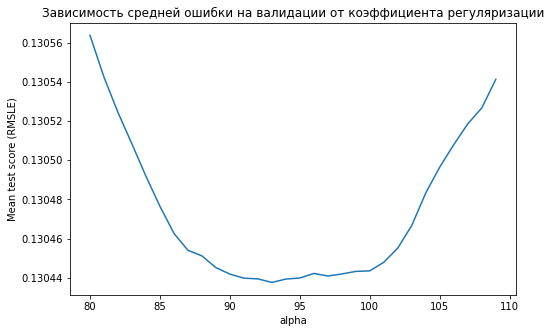

In [70]:
plt.figure(figsize=(8, 5))
plt.plot(lasso_alphas, -lasso_cv_mean_test_score)
plt.xlabel('alpha')
plt.ylabel('Mean test score (RMSLE)')
plt.title('Зависимость средней ошибки на валидации от коэффициента регуляризации');

#### Динамика весов при увеличении параметра регуляризации 

In [71]:
column_based_pipeline = lasso_pipeline.named_steps['preprocessing'].named_steps['column_based_preprocess_pipeline']

numeric_feature_names = np.array(column_based_pipeline.transformers_[0][2])
#print(numeric_feature_names)

cat_feature_names = np.array(column_based_pipeline.transformers_[1][1].named_steps['one_hot_encoder'].get_feature_names())
#print(type(numeric_feature_names))

feature_names = np.concatenate([numeric_feature_names, cat_feature_names])
feature_names_series = pd.Series(feature_names)
print(feature_names[29])
#print(feature_names_series[feature_names_series == 'GarageCars'])

EnclosedPorch


In [72]:
lasso_alphas_plot = np.arange(0, 600, 50)
lasso_alpha_coefs_matrix = np.zeros((lasso_alphas_plot.shape[0], feature_names.shape[0]))

lasso_model_plot = Lasso(max_iter=5000, selection='random', random_state=19)
lasso_pipeline_plot = Pipeline([('preprocessing', preprocessing_pipeline), ('model', lasso_model_plot)])

for idx, alpha in enumerate(lasso_alphas_plot):
    lasso_model_plot.alpha = alpha
    lasso_pipeline_plot.fit(df_data_X, df_data_y)
    lasso_alpha_coefs_matrix[idx,:] = lasso_pipeline_plot.named_steps['model'].coef_

D:\anaconda3\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276969946270.4878, tolerance: 920745877.805445
  model = cd_fast.sparse_enet_coordinate_descent(


In [73]:
print(lasso_alpha_coefs_matrix.shape)

(12, 291)


Text(0.5, 1.0, 'SF features')

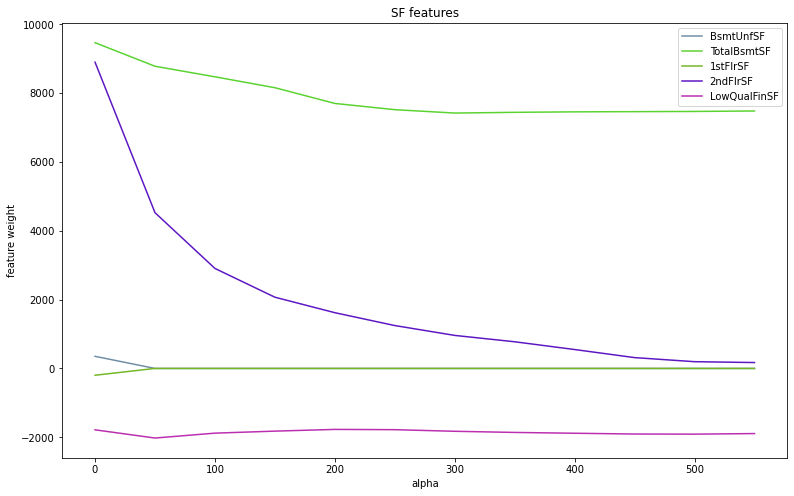

In [74]:
plt.figure(figsize=(13, 8))
for coefs_for_alpha, feature in zip(lasso_alpha_coefs_matrix.T[10:15], feature_names[10:15]):
    plt.plot(lasso_alphas_plot, coefs_for_alpha, color=np.random.rand(3), label=feature)
plt.legend(loc="upper right")
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("SF features")

Text(0.5, 1.0, 'Garage features')

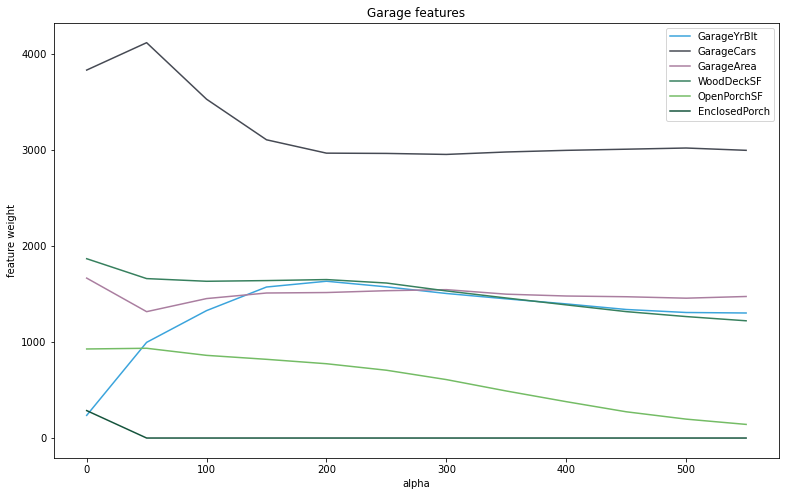

In [75]:
plt.figure(figsize=(13, 8))
for coefs_for_alpha, feature in zip(lasso_alpha_coefs_matrix.T[24:30], feature_names[24:30]):
    plt.plot(lasso_alphas_plot, coefs_for_alpha, color=np.random.rand(3), label=feature)
plt.legend(loc="upper right")
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Garage features")

Text(0.5, 1.0, 'SaleCondition categorical feature')

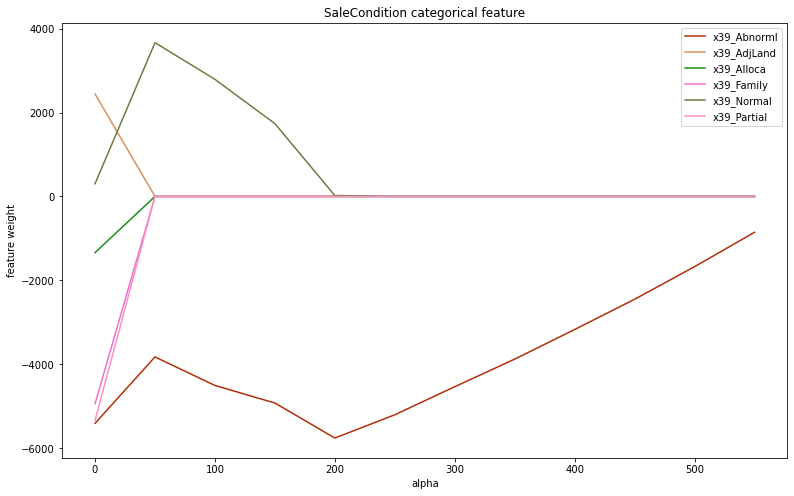

In [76]:
plt.figure(figsize=(13, 8))
for coefs_for_alpha, feature in zip(lasso_alpha_coefs_matrix.T[-6:], feature_names[-6:]):
    plt.plot(lasso_alphas_plot, coefs_for_alpha, color=np.random.rand(3), label=feature)
plt.legend(loc="upper right")
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("SaleCondition categorical feature")

#### Train the best estimator 

In [77]:
lasso_best_estimator = lasso_grid_cv.best_estimator_

In [78]:
%%time
lasso_best_estimator.fit(df_data_X, df_data_y);

Wall time: 422 ms


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x000002BB82E86790>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002BB82E86880>),
                                                                  ('categorical',
                              

In [79]:
lasso_predicted_y = lasso_best_estimator.predict(df_data_X)

In [80]:
lasso_trained_model = lasso_best_estimator.named_steps['model']
print('Number of non-zero features after the training:')
print(np.count_nonzero(lasso_trained_model.coef_))
print('Initial number of features:')
print(lasso_trained_model.coef_.size)

Number of non-zero features after the training:
121
Initial number of features:
291


In [81]:
print(lasso_trained_model.coef_[:50])
print(lasso_trained_model.coef_[-50:])

[-3655.53328982  2065.21146956  4312.28112055 10321.40470073
  6661.55588312  9274.2040369   1172.21072189  3996.59467449
  7623.84451182   741.87367408    -0.          8531.65744362
     0.          3139.29429756 -1897.78408489 28502.18682645
   469.92581455  -336.41245536  1430.40245432   351.64222329
 -4433.64225415 -3426.74865261  1717.23676451  1929.4142699
  1284.4530948   3623.08949925  1426.0597998   1630.24266894
   871.15079615    -0.           408.1603128   1561.4141582
  3273.70010453  -252.65236067  -665.26847795  -154.49307399
 -7339.20838835  1445.02410068     0.           186.13121634
 -4305.06330855  -742.61604077    61.52974543  -109.8298473
   308.8607922     -0.             0.            -0.
  1142.11752617 -2472.38783634]
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  3.96157581e+02 -1.17563359e+03 -0.00000000e+00
  2.49211416e+03 -0.00000000e+00  0.00000000e+00  8.47026110e+01
 -0.00000000e+00 -2.11827858e+03  0.00000000e+00  9.

In [82]:
error = mean_squared_error(np.log(df_data_y), np.log(lasso_predicted_y), squared=False)
print("LassoCV. Error on the whole training set: {}".format(error))

LassoCV. Error on the whole training set: 0.11777743750277313


По результатам на test set модель Lasso показало немного лучший результат, чем Ridge.
Также и разница в ошибке между train и test для Lasso меньше.
Видно, что было исключено более половины признаков.

#### Custom log rmse metric to handle negative values

Причина ошибки "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')." в том, что в y_pred иногда встречается отрицательное значение. Пример: -2958.13996099
Надо добавить проверку в функцию-метрику. Они соответствуют относительно небольшим истинным значениям ответа. 
Например:
375     61000
533     39300 

Что делать с этим отрицательным значением?..

In [83]:
def rmse_full_scale_log(x):
    """
    Compute np.log element-wise to be used in log_rmse.
    Negative values and values from the [0, 1] are handled in a specific way.
    WARN: LOOK LIKE IT WORKS INCORRECT.
    """
    x_result = np.array(x)
    regular_values_mask = x > 1
    negative_values_mask = x < 0
    zero_one_values_mask = (x >= 0) & (x <= 1)
    x_result[regular_values_mask] = np.log(x[regular_values_mask])
    x_result[negative_values_mask] = np.log(-x[negative_values_mask])
    x_result[zero_one_values_mask] = 0
    return x_result

In [84]:
log_rmse_full_scale_metric = make_scorer(lambda y_true, y_pred: \
                            mean_squared_error(rmse_full_scale_log(y_true), rmse_full_scale_log(y_pred), squared=False), \
                                     greater_is_better=False)

In [85]:
test_array = np.array([50000, -5300, 10000, 0.5, -197])
print(log_full_scale(np.array(test_array)))

NameError: name 'log_full_scale' is not defined

### Lasso 2 (category ordinal encoding) --- test 

In [207]:
lasso_model = Lasso(max_iter=5000, selection='random', random_state=19)
lasso_pipeline = Pipeline([('preprocessing', preprocessing_pipeline_cat_ordinal), ('model', lasso_model)])

In [208]:
#lasso_pipeline.get_params()
lasso_alphas = range(50, 110, 5)
lasso_parameters_grid = {'model__alpha': lasso_alphas}
lasso_grid_cv = GridSearchCV(lasso_pipeline, lasso_parameters_grid, scoring=log_rmse_metric, cv=10)

In [209]:
%%time
lasso_grid_cv.fit(df_data_X, df_data_y)

Wall time: 1min 44s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('remove_columns',
                                                         <__main__.DataFrameColumnsRemove object at 0x0000026032CE01F0>),
                                                        ('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                          

In [210]:
print(lasso_grid_cv.best_score_)
print(lasso_grid_cv.best_params_)

-0.13043986759509937
{'model__alpha': 95}


С использованием Category ordinal encoding результат для LASSO намного хуже, чем без него.

### Model 4. ElasticNet 

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
elastic_net_model = ElasticNet(max_iter=100000, selection='random', random_state=19)
elastic_net_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', elastic_net_model)])

In [ ]:
elastic_net_alphas = np.linspace(0.2, 0.8, num=4)
elastic_net_l1_ratio = np.linspace(0.9, 0.99, num=5)

In [ ]:
elastic_net_parameters_grid = {'model__alpha': elastic_net_alphas, 'model__l1_ratio': elastic_net_l1_ratio}
elastic_net_grid_cv = GridSearchCV(elastic_net_pipeline, elastic_net_parameters_grid, scoring=log_rmse_metric, cv=20, n_jobs=2)

In [ ]:
%%time
elastic_net_grid_cv.fit(df_data_X, df_data_y)

In [ ]:
print(elastic_net_grid_cv.best_score_)
print(elastic_net_grid_cv.best_params_)

In [ ]:
elastic_net_best_estimator = elastic_net_grid_cv.best_estimator_

In [ ]:
elastic_net_predicted_y = elastic_net_best_estimator.predict(df_data_X)

In [ ]:
error = mean_squared_error(np.log(df_data_y), np.log(elastic_net_predicted_y), squared=False)
print("ElasticNetCV. Error on the whole training set: {}".format(error))

On test set Lasso looks better than ElasticNet.

##### [Experiments] with SGDRegressor. Errors with "log"...

Info about SGD:
https://scikit-learn.org/stable/modules/sgd.html#sgd

"SGDRegressor is well suited for regression problems with a large number of training samples (> 10.000), for other problems we recommend Ridge, Lasso, or ElasticNet."

In [ ]:
sgd_ridge_model = linear_model.SGDRegressor(random_state=19, loss='squared_loss', penalty='l2')
sgd_ridge_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', sgd_ridge_model)])

In [ ]:
parameters_grid = {'model__alpha': [0.080, 0.01, 0.02, 0.03, 0.04]}
sgd_ridge_grid_cv = GridSearchCV(sgd_ridge_pipeline, parameters_grid, scoring=log_rmse_metric, cv=10)

In [ ]:
%%time
sgd_ridge_grid_cv.fit(train_X, train_y)

In [ ]:
print(sgd_ridge_grid_cv.best_score_)
print(sgd_ridge_grid_cv.best_params_)


Что интересно, на SGD результаты выглядят хуже.

Со временем, надо разобраться с этой ошибкой:

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

//--//

### Model 6. Bagging

Docs:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

Note:

In theory, categories themselves can be handled in decision trees. However, most python implementations will only work with numbers, so you need to convert them. 

In [87]:
from sklearn.ensemble import BaggingRegressor

In [103]:
bagging_regressor_model = BaggingRegressor()
bagging_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', bagging_regressor_model)])

In [109]:
bagging_n_estimators = range(10, 13)
bagging_parameters_grid = {'model__n_estimators': bagging_n_estimators}
bagging_grid_cv = GridSearchCV(bagging_pipeline, bagging_parameters_grid, scoring=log_rmse_metric, cv=10)

In [110]:
bagging_grid_cv.fit(df_data_X, df_data_y)

Wall time: 49.6 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('remove_columns',
                                                         <__main__.DataFrameColumnsRemove object at 0x000002BB853C38B0>),
                                                        ('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                          

In [111]:
print(bagging_grid_cv.best_score_)
print(bagging_grid_cv.best_params_)

-0.14537098398570575
{'model__n_estimators': 12}


### Model 7. Random Forest 

Docs:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [155]:
from sklearn.ensemble import RandomForestRegressor

#### Baseline model

In [32]:
rforest_baseline_model = RandomForestRegressor(random_state=19)
rforest_baseline_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', rforest_baseline_model)])

In [158]:
rforest_baseline_pipeline.fit(df_data_X, df_data_y);

In [159]:
rforest_predicted_y = rforest_baseline_pipeline.predict(df_data_X)

In [160]:
rforest_baseline_error = mean_squared_error(np.log(df_data_y), np.log(rforest_predicted_y), squared=False)
print("RandomForest. Baseline score on the training set: {}".format(rforest_baseline_error))

RandomForest. Baseline score on the training set: 0.056565297017220975


На тесте результат для baseline-модели намного хуже: 0.14899

#### Построение валидационных кривых (validation curves)

In [35]:
rforest_baseline_model = RandomForestRegressor(random_state=19)
rforest_baseline_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', rforest_baseline_model)])

In [66]:
rforest_baseline_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'model', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__remove_columns', 'preprocessing__column_based_preprocess_pipeline', 'preprocessing__column_based_preprocess_pipeline__n_jobs', 'preprocessing__column_based_preprocess_pipeline__remainder', 'preprocessing__column_based_preprocess_pipeline__sparse_threshold', 'preprocessing__column_based_preprocess_pipeline__transformer_weights', 'preprocessing__column_based_preprocess_pipeline__transformers', 'preprocessing__column_based_preprocess_pipeline__verbose', 'preprocessing__column_based_preprocess_pipeline__numerical', 'preprocessing__column_based_preprocess_pipeline__categorical', 'preprocessing__column_based_preprocess_pipeline__numerical__memory', 'preprocessing__column_based_preprocess_pipeline__numerical__steps', 'preprocessing__column_based_preprocess_pipeline__numerical__verbose', 'preprocessing__column_based_preprocess_pipeline__n

In [85]:
def build_validation_curve(estimator, param_name, param_range, x_label, ylim):
    train_scores, test_scores = validation_curve(estimator, df_data_X, df_data_y, \
                                                param_name=param_name, param_range=param_range, \
                                                cv=5, scoring=log_rmse_metric, n_jobs=-1)
    train_scores = np.negative(train_scores)
    test_scores = np.negative(test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print("Cross-validation scores:")
    print(test_scores_mean)
    
    plt.figure(figsize=(12, 8))
    plt.title("Validation Curve with Random Forest for " + x_label)
    plt.xlabel(x_label)
    plt.ylabel("Error (RMSLE)")
    plt.ylim(ylim[0], ylim[1])
    plt.grid()
    plt.plot(param_range, train_scores_mean, color='orange', label="Training error")
    plt.fill_between(param_range, \
                 train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='orange')
    plt.plot(param_range, test_scores_mean, color='blue', label="Cross-validation error")
    plt.fill_between(param_range, \
                 test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='blue')
    plt.legend(loc='best')

#### Подбор количества деревьев 

In [34]:
n_estimators_param_range = [5, 10, 15, 20, 30, 50, 75, 100, 120, 150, 200]

Cross-validation scores:
[0.15722435 0.1483364  0.1453785  0.14369609 0.1422383  0.14109673
 0.14102912 0.14136281 0.14094948 0.14081105 0.14054345]


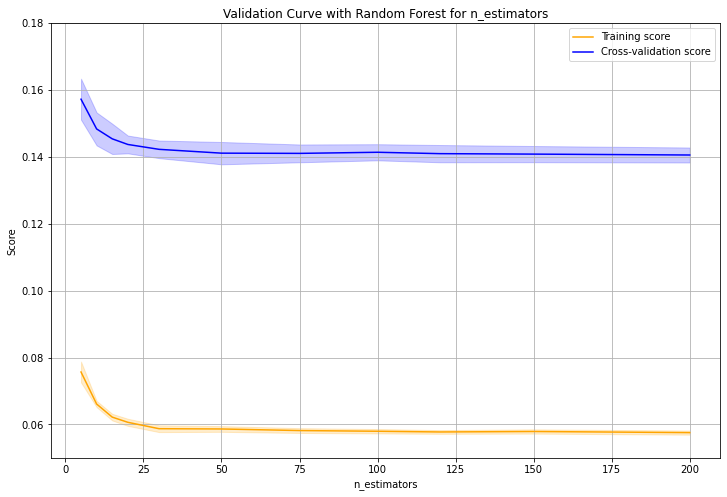

In [68]:
build_validation_curve(rforest_baseline_pipeline, "model__n_estimators", n_estimators_param_range, "n_estimators", (0.05, 0.18))

# Use sklearn.model_selection.KFold OR model_selection.validation_curve(estimator, …)
#train_scores, test_scores = validation_curve(rforest_baseline_pipeline, df_data_X, df_data_y, \
#                                             param_name="model__n_estimators", param_range=n_estimators_param_range, \
#                                             cv=5, scoring=log_rmse_metric, n_jobs=-1)

No handles with labels found to put in legend.


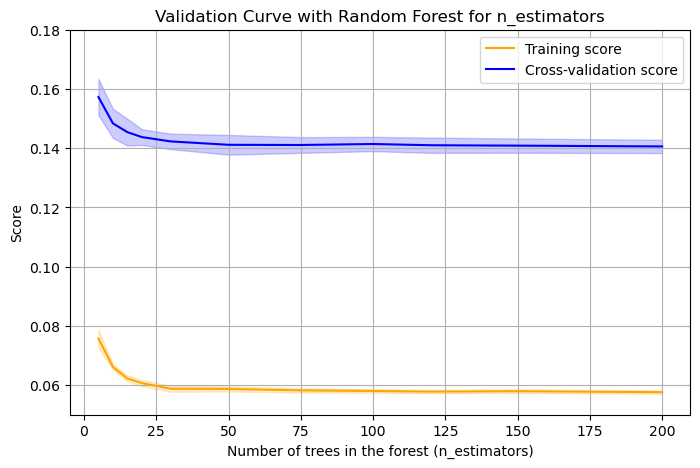

In [132]:
plt.figure(figsize=(8, 5))
plt.legend(loc="upper right")
plt.title("Validation Curve with Random Forest for n_estimators")
plt.xlabel("Number of trees in the forest (n_estimators)")
plt.ylabel("Score")
plt.ylim(0.05, 0.18)
plt.grid()
plt.plot(n_estimators_param_range, train_scores_mean, color='orange', label="Training score")
plt.fill_between(n_estimators_param_range, \
                 train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='orange')
plt.plot(n_estimators_param_range, test_scores_mean, color='blue', label="Cross-validation score")
plt.fill_between(n_estimators_param_range, \
                 test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='blue')
plt.legend(loc='best')
plt.show()

Начиная где-то от 50 деревьев ошибка на валидации уже почти не меняется, только по чуть-чуть уменьшается.

Далее: посмотреть другие параметры: например, макс. глубина дерева, кол-во признаков и др.

#### Максимальная глубина дерева 

In [64]:
max_depth_param_range = range(5, 28, 3)

Cross-validation scores:
[0.16750513 0.1465896  0.14204069 0.14158158 0.1415205  0.14166949
 0.14152102 0.14139846]


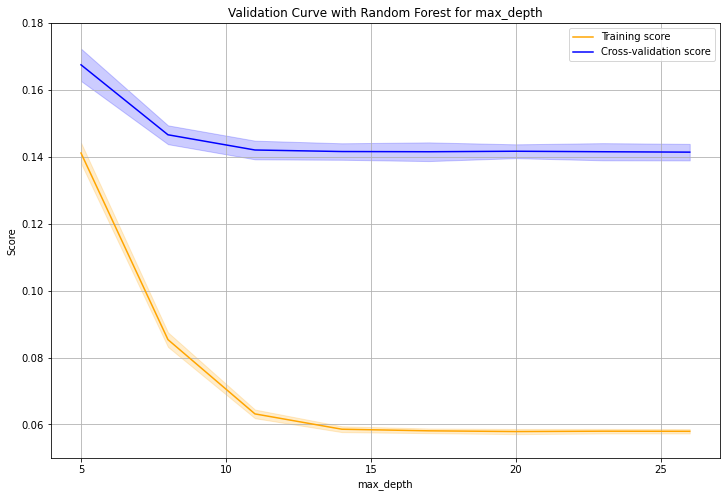

In [65]:
# n_estimator=100 by default
build_validation_curve(rforest_baseline_pipeline, "model__max_depth", max_depth_param_range, "max_depth", (0.05, 0.18))

#### Минимальное число объектов в листе 

In [78]:
min_samples_leaf_param_range = range(1, 16)
print(*min_samples_leaf_param_range)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15


Cross-validation scores:
[0.14136281 0.14140184 0.14225086 0.14318385 0.14451729 0.14561663
 0.14733512 0.14891694 0.15013224 0.15140449 0.15263465 0.15410379
 0.15523348 0.15661442 0.15812329]


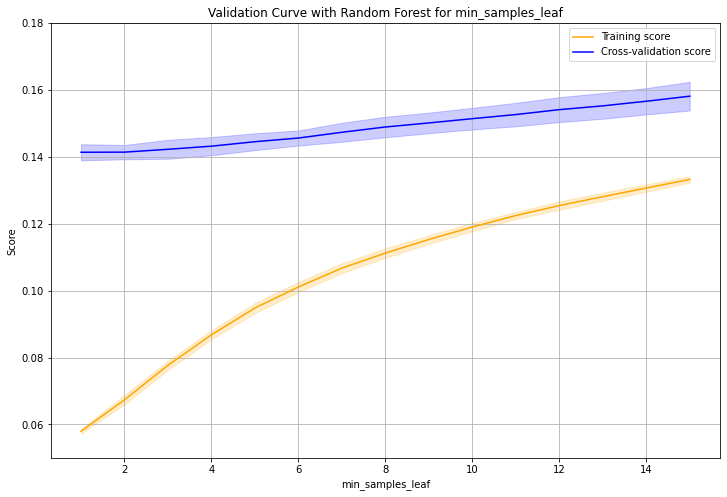

In [79]:
build_validation_curve(rforest_baseline_pipeline, "model__min_samples_leaf", \
                       min_samples_leaf_param_range, "min_samples_leaf", (0.05, 0.18))

При увеличении min_samples_leaf ошибка на валидации увеличивается, но зато и уменьшается эффект переобучения, т.к. значение ошибки на тренировочной выборке приближается к ошибке на валидации. Без особых потерь можно было бы взять min_samples_leaf=5. Увеличение min_samples_leaf, согласно документации, имеет сглаживающий эффект.

#### Число признаков, по которым ищется разбиение

In [95]:
features_total = 291
max_features_param_range = [2, 4, 8, 16, 32, 64, 100, 128, 160, 200, 256, 280]
print(*max_features_param_range)

2 4 8 16 32 64 100 128 160 200 256 280


Cross-validation scores:
[0.1742152  0.16398897 0.15440317 0.14496509 0.14058647 0.1375697
 0.13655512 0.13764097 0.13791636 0.13923674 0.13998817 0.14121927]


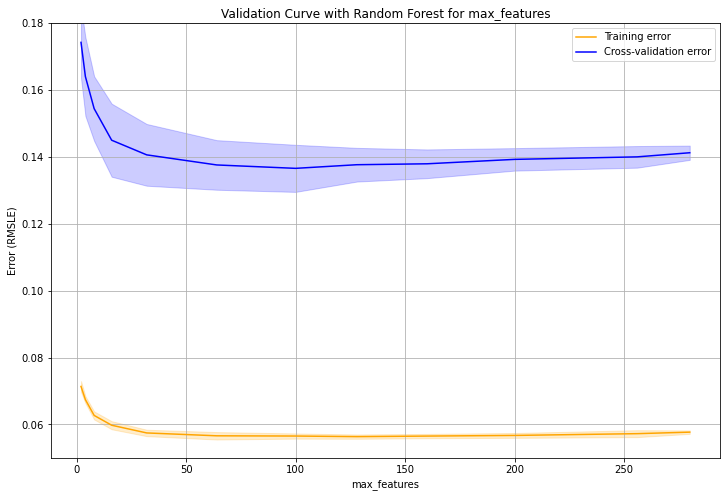

In [96]:
build_validation_curve(rforest_baseline_pipeline, "model__max_features", \
                       max_features_param_range, "max_features", (0.05, 0.18))

Лучшие результаты получаются примерно на 100 признаках. Это как раз примерно соответствует эмпирической рекомендации в max_features = n/3 для задачи регрессии, где n -- общее количество признаков.
Здесь должно соблюдаться то, что за счет неполного числа используемых признаков мы получаем разные подмножества признаков и уменьшаем коррелированность ошибок между базовыми алгоритмами, они должны получаться более разнообразными.

Почему-то при задании max_features=291 результат = nan... Надо будет посмотреть, сколько в итоге признаков получилось. Судя по прошлым моделям, должно быть 291

Далее: провести кросс-валидацию с целью нахождения оптимального множества значений параметров

#### Подбор оптимальных параметров модели

In [73]:
# assume n_estimators=150
rforest_n_estimators=150
rforest_model = RandomForestRegressor(n_estimators=rforest_n_estimators, random_state=19)
rforest_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', rforest_model)])

In [ ]:
rforest_max_depth_range = [10, 20, 30]
rforest_min_samples_leaf_range = [1, 2, 3, 4, 5, 8, 10]
rforest_max_features_range = [80, 100, 120, 200, 280]

In [33]:
rforest_parameters_grid = {'model__max_depth': rforest_max_depth_range, \
                           'model__min_samples_leaf': rforest_min_samples_leaf_range, \
                           'model__max_features': rforest_max_features_range}

rforest_grid_cv = GridSearchCV(rforest_pipeline, rforest_parameters_grid, scoring=log_rmse_metric, cv=8, n_jobs=-1)

In [34]:
%%time
rforest_grid_cv.fit(df_data_X, df_data_y)

Wall time: 37min 59s


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('remove_columns',
                                                         <__main__.DataFrameColumnsRemove object at 0x0000016CCB1A4850>),
                                                        ('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                           

In [35]:
print(rforest_grid_cv.best_score_)
print(rforest_grid_cv.best_params_)

-0.13432571522223286
{'model__max_depth': 30, 'model__max_features': 100, 'model__min_samples_leaf': 1}


In [42]:
rforest_best_estimator = rforest_grid_cv.best_estimator_
rforest_trained_model = rforest_best_estimator.named_steps['model']
print('Check the number of features:')
print(rforest_trained_model.n_features_)

Check the number of features:
291


In [29]:
#rforest_max_depth_range_2 = [30, 50, 100]
rforest_max_features_range_2 = [95, 100, 105, 110, 115]

#rforest_model_2 = RandomForestRegressor(n_estimators=rforest_n_estimators)
#rforest_pipeline_2 = Pipeline([('preprocessing', preprocessing_pipeline), ('model', rforest_model_2)])

In [30]:
rforest_parameters_grid_2 = {'model__max_features': rforest_max_features_range_2}
rforest_grid_cv_2 = GridSearchCV(rforest_pipeline, rforest_parameters_grid_2, scoring=log_rmse_metric, cv=7, n_jobs=-1)

In [31]:
%%time
rforest_grid_cv_2.fit(df_data_X, df_data_y)

Wall time: 2min 39s


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('remove_columns',
                                                         <__main__.DataFrameColumnsRemove object at 0x0000026D27B21430>),
                                                        ('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                           

In [32]:
print(rforest_grid_cv_2.best_score_)
print(rforest_grid_cv_2.best_params_)

-0.1357987556990535
{'model__max_features': 100}


In [33]:
rforest_best_estimator_2 = rforest_grid_cv_2.best_estimator_
rforest_trained_model_2 = rforest_best_estimator_2.named_steps['model']

In [66]:
trees_depth = [estimator.get_depth() for estimator in rforest_trained_model_2.estimators_]
trees_depth = np.array(trees_depth)

In [72]:
print("Base algorithms. Decision tree depth. Mean: {}, Std: {}".format(trees_depth.mean(), trees_depth.std()))

Base algorithms. Decision tree depth. Mean: 23.64, Std: 2.139408017809288


Выбрать модель. Узнать получившуюся глубину дерева при max_depth=None.
Попробовать min_samples_leaf > 1

#### Random Forest. Train the final estimator

In [153]:
rforest_final_model = RandomForestRegressor(n_estimators=2000, max_features=100, oob_score=True, n_jobs=-1)
rforest_final_pipeline = Pipeline([('preprocessing', preprocessing_pipeline), ('model', rforest_final_model)])

In [154]:
%%time
rforest_final_pipeline.fit(df_data_X, df_data_y)

Wall time: 1min 40s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x0000026D27B21430>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x...),
                                                                  ('categorical',
                                            

In [155]:
rforest_final_trained_model.oob_prediction_

array([206514.50688705, 168528.55088195, 214911.10427807, ...,
       238195.6251768 , 133871.6171875 , 152292.90670171])

In [156]:
rforest_predicted_y = rforest_final_pipeline.predict(df_data_X)

error = mean_squared_error(np.log(df_data_y), np.log(rforest_predicted_y), squared=False)
print("Random Forest. Error on the training set: {}".format(error))

Random Forest. Error on the training set: 0.053940088538112656


In [157]:
rforest_final_trained_model = rforest_final_pipeline.named_steps['model']
print("R^2 out-of-bag score: {}".format(rforest_final_trained_model.oob_score_))
rforest_oob_predicted_y = rforest_final_trained_model.oob_prediction_

error = mean_squared_error(np.log(df_data_y), np.log(rforest_oob_predicted_y), squared=False)
print("Random Forest. Out-of-bag error on the training set: {}".format(error))

R^2 out-of-bag score: 0.9010097452503602
Random Forest. Out-of-bag error on the training set: 0.13447565458066948


Случайный лес пока что не показывает чего-то выдающегося. На тесте ошибка равна около 0.145, что больше, чем в Лассо и гребневой регрессии. На тренировочной выборке out-of-bag error равен примерно 0.1344.
Возможно, где-то есть нюансы на уровне предобработки данных....

Далее: попробовать преобразовать категориальные признаки в числовые (порядковые)
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/32425

#### Random Forest. Ordinal Encoder

In [185]:
rforest_final_model = RandomForestRegressor(n_estimators=2000, max_features=70, oob_score=True, n_jobs=-1)
rforest_final_pipeline = Pipeline([('preprocessing', preprocessing_pipeline_cat_ordinal), ('model', rforest_final_model)])

In [186]:
%%time
rforest_final_pipeline.fit(df_data_X, df_data_y)

Wall time: 15.3 s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('remove_columns',
                                  <__main__.DataFrameColumnsRemove object at 0x0000026034065EE0>),
                                 ('custom_ordinal_encoder',
                                  <__main__.CustomOrdinalEncoder object at 0x0000026034065F40>),
                                 ('column_based_preprocess_pipeline',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    St...
                                                                   <sklearn.compose._column_transformer.make_column_selector ob

In [187]:
rforest_predicted_y = rforest_final_pipeline.predict(df_data_X)

error = mean_squared_error(np.log(df_data_y), np.log(rforest_predicted_y), squared=False)
print("Random Forest. Error on the training set: {}".format(error))

Random Forest. Error on the training set: 0.05362629704132


In [188]:
rforest_final_trained_model = rforest_final_pipeline.named_steps['model']
print("R^2 out-of-bag score: {}".format(rforest_final_trained_model.oob_score_))
rforest_oob_predicted_y = rforest_final_trained_model.oob_prediction_

error = mean_squared_error(np.log(df_data_y), np.log(rforest_oob_predicted_y), squared=False)
print("Random Forest. Out-of-bag error on the training set: {}".format(error))

R^2 out-of-bag score: 0.9015133403161631
Random Forest. Out-of-bag error on the training set: 0.13344305415370522


Использование Ordinal Feature Encoding улучшило результат только на 0.001.

#### Предсказания в Kaggle

In [163]:
df_test_data = pd.read_csv('data/test.csv')
final_test_predictions = pd.Series(rforest_final_pipeline.predict(df_test_data))

In [164]:
final_result = pd.concat([df_test_data['Id'], final_test_predictions], axis=1, keys=['Id', 'SalePrice'])
final_result

,Id,SalePrice
0,1461,126926.6905
1,1462,153740.4795
2,1463,179893.4765
3,1464,183771.9780
4,1465,195928.0830
...,...,...
1454,2915,86374.7305
1455,2916,87066.7240
1456,2917,157493.5465
1457,2918,114349.1250


In [166]:
final_result.to_csv('output\\random_forest_cat_ordinal_encoder_estimators_2000_max_features_70.csv', sep=',', header=True, index=False)

Удалить признаки с большим кол-вом пропусков (> 90%), по остальным, возможно, проанализировать корреляцию, посмотреть, почему они пустые, возможно, использовать SimpleImputer.

Анализировал пропущенные значения. Пока думаю так: 
* удалить колонки с > 90% пропущенного на train. Это PoolQC, MiscFeature, Alley.
* для категориальных признаков: пропущенное значение выделить в отдельную категорию. Назвать ее как-то
* для числовых признаков: Применить Imputer, strategy=mean

Затем определиться со схемой валидации: hold-out, cross-validation? плюсы/минусы.
После чего можно попробовать запустить линейную регрессию.
Держим в уме масштабирование признаков для нормальной работы градиентного спуска, а также мультиколлинеарность и регуляризацию.
Попробуем запустить без них, чтобы посмотреть на качество модели.
Интересно посмотреть на влияние мультиколлинеарности, посмотреть на неустойчивость и попробовать определить число обусловленности матрицы.